## Preparations

### load Modules

In [1]:
%load_ext autoreload
%autoreload 2


#from deepgreen import *
import pandas as pd
import json
from dotenv import load_dotenv
import os
from pathlib import Path

from sentinelhub.api.catalog import SentinelHubCatalog

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    OsmSplitter,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    read_data,
    bbox_to_dimensions,
)


#from functions.cloud_coverage_functions import *
from functions.html_table_functions import *
from functions.plot_functions import *
from functions.sentinel_hub_functions import *



### Init Config

In [ ]:
load_dotenv()

CONFIG = SHConfig()
# TODO: Gaht nöd
CONFIG.sh_client_id = ''
CONFIG.sh_client_secret = ''


### Define and Segment AOI

In [3]:
# Define area of intrest (Winterthur)
aoi = BBox(bbox = (8.629496, 47.421583, 8.884906,47.58301), 
              crs = CRS.WGS84)

# Segment area of intrest into smaller regions
aoi_wt_segments = segment_aoi(aoi = aoi, resolution = 10, output = "grid")

# Create aoi segment id to bbox map dict
aoi_bbox_dict = create_aoi_bbox_dict(aoi_wt_segments)

### Create Catalog

In [4]:
# Initialize Sentinelhub Catalog Object
catalog_obj = SentinelHubCatalog(config=CONFIG)

# Define time interval
time_intervall = "2025-03-01", "2025-04-20"

# create aoi catalog for specified time interval and store it as json file
aoi_catalog = create_aoi_catalog_dict(catalog = catalog_obj, 
                                      time_interval = time_intervall, 
                                      aoi_bbox_dict = aoi_bbox_dict, 
                                      save_file = True,
                                      file_name = "winterthur_2025_aoi_catalog.json",
                                      dir_path = Path("data")
                                      )

## Download Images

### set test parameters

In [5]:
id = '0000'
ts = '2025-04-08'
res = 10
bbox = aoi_bbox_dict[id]
bbox_size = bbox_to_dimensions(bbox, resolution=res)

### Functions

#### Function to get images with evalscript

In [6]:
def get_image(es, ts, bbox, bbox_size, config):
    request_image = SentinelHubRequest(
        evalscript=es,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=ts,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=bbox_size,
        config=config,
    )
    imgs = request_image.get_data()
    img = imgs[0]
    return img

#### function to plot image

In [ ]:
import matplotlib.pyplot as plt
def show_img(img):
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks for a cleaner image display
    plt.show()

### get images

#### built up area

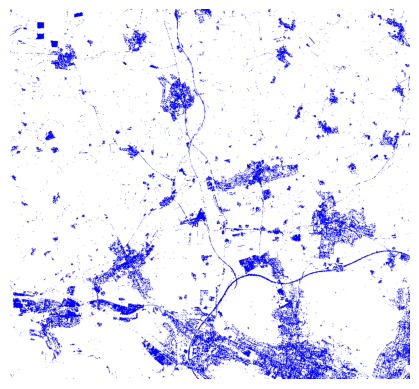

In [13]:
es_bua = load_eval_script("eval_scripts/es_bua.js")
img_bua = get_image(es = es_bua, ts = ts, bbox = bbox, bbox_size = bbox_size, config = CONFIG)
show_img(img_bua)

#### bua confidence

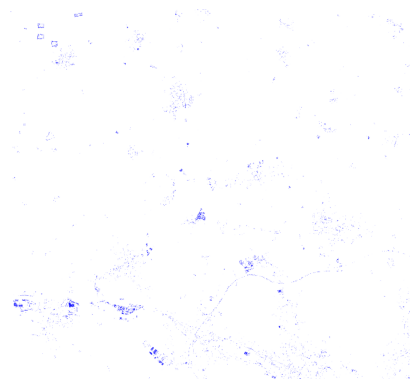

In [23]:
es_bua_conf = load_eval_script("eval_scripts/es_bua_confidence.js")
img_bua_conf = get_image(es = es_bua_conf, ts = ts, bbox = bbox, bbox_size = bbox_size, config = CONFIG)
show_img(img_bua_conf)

#### green city

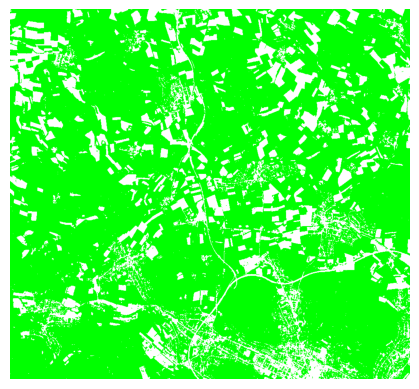

In [14]:
es_gc = load_eval_script("eval_scripts/es_gc.js")
img_gc = get_image(es = es_gc, ts = ts, bbox = bbox, bbox_size = bbox_size, config = CONFIG)
show_img(img_gc)

#### gc confidence

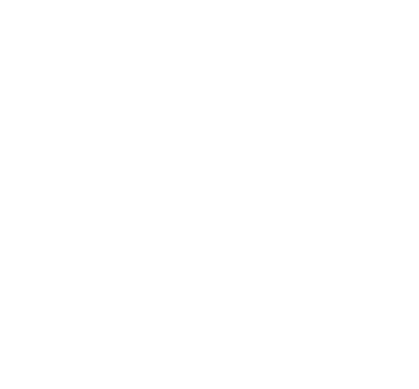

In [25]:
es_gc_conf = load_eval_script("eval_scripts/es_gc_conf.js")
img_gc_conf = get_image(es = es_gc_conf, ts = ts, bbox = bbox, bbox_size = bbox_size, config = CONFIG)
show_img(img_gc_conf)

#### merged

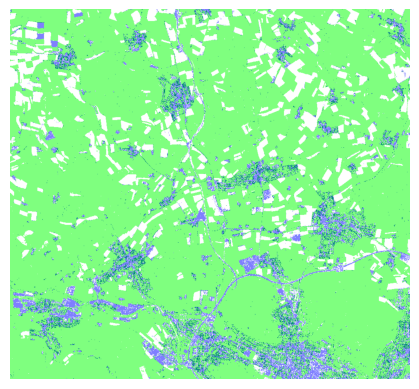

In [19]:
blended_bua_gc = (0.5 * img_bua + 0.5 * img_gc).astype(np.uint8)

show_img(blended_bua_gc)

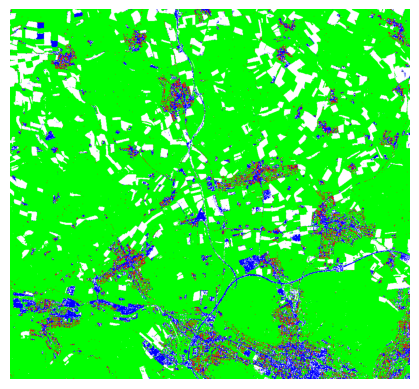

In [20]:
import numpy as np

def overlay_images(img1, img2):
    # Create an empty output image
    result = np.zeros_like(img1)

    # Create masks
    white = np.array([255, 255, 255])
    is_white1 = np.all(img1 == white, axis=-1)
    is_white2 = np.all(img2 == white, axis=-1)

    # Both are white → keep white
    both_white = is_white1 & is_white2
    result[both_white] = white

    # img1 non-white, img2 white → use img1 pixel
    only_img1 = ~is_white1 & is_white2
    result[only_img1] = img1[only_img1]

    # img2 non-white, img1 white → use img2 pixel
    only_img2 = is_white1 & ~is_white2
    result[only_img2] = img2[only_img2]

    # both non-white → set to red
    both_non_white = ~is_white1 & ~is_white2
    result[both_non_white] = [255, 0, 0]

    return result

merged = overlay_images(img_gc, img_bua)
show_img(merged)

#### cloud mask

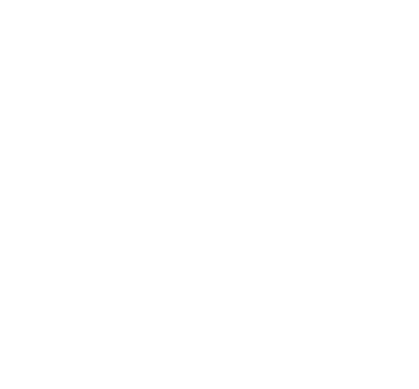

In [16]:
es_clm = load_eval_script("eval_scripts/es_clm.js")
img_clm = get_image(es = es_clm, ts = ts, bbox = bbox, bbox_size = bbox_size, config = CONFIG)
show_img(img_clm)

### show images

#### built up area

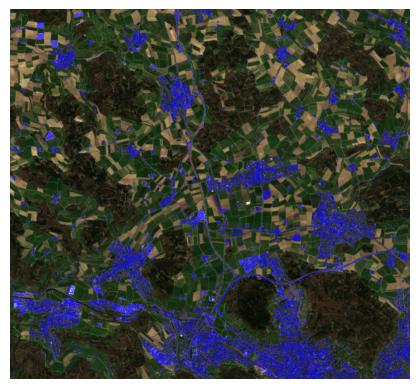

In [12]:
show_img(img_bua)